## Training Recurrant Neural Networks
In this notebook we train RNNs for the task of *sentiment analysis*. Such tasks correspond to identifying the sentiment of the writer from a piece of text, and can be viewed as *many-to-one* time sequence processing. In particular, we will train two RNN types - a vanilla RNN and a GRU - for classifying tweets to either *happy* or *sad*.

Since we are dealing with text processing, we will need to convert words into vectors which can be fed as input to the neural network. For this reason we include the package *torchtext* which provides these capbilities, as we show next.

In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext import vocab
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
random.seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install torchinfo
from torchinfo import summary

# Sentiment140 Dataset
The data set we will use is the Sentiment140 data set, which contains tweets with either a positive or negative emotion. This dataset was collected by a group of students from Stanford who were working on machine learning projects.

This dataset should be downloaded [manually](https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit?resourcekey=0-betyQkEmWZgp8z0DFxWsHw) by unzipping the csv file named `training.1600000.processed.noemoticon.csv`, then place it in your desirable google drive directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pwd

data = csv.reader(open("/content/drive/MyDrive/IntroToDeep/Fall 2023/Excercises/W9 - RNNs twitts/training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))


Mounted at /content/drive
/content


Let's see what this data looks like, printing the first 10 entries.

In [ ]:
for i, line in enumerate(data):
  if i > 10:
    break
  print(line)

['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"]
['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467810917', 'Mon Apr 06 22:19:53 PDT 2009', 'NO_QUERY', 'mattycus', '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds']
['0', '1467811184', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'ElleCTF', 'my whole body feels itchy and like its on fire ']
['0', '1467811193', 'Mon Apr 06 22:19:57 PDT 2009', 'NO_QUERY', 'Karoli', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
['0', '1467811372', 'Mon Apr 06 22:20:00 PDT 2009', 'NO_QUERY', 'joy_wolf', '@Kwesidei not the whole crew ']
['0', '14

The columns we care about is the first one and the last one. The first column is the label (the label 0 means "sad" tweet, 4 means "happy" tweet), and the last column contains the tweet. Our task is to predict the sentiment of the tweet given the text.

We will need to split the text into words. We will do so by splitting at all whitespace characters. There are better ways to perform the split, but let's keep our dependencies light.

In [ ]:
def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

tweet = next(data)[-1]
print(tweet)
print(split_tweet(tweet))

@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .
['@caregiving', 'i', "couldn't", 'bear', 'to', 'watch', 'it', '.', 'and', 'i', 'thought', 'the', 'ua', 'loss', 'was', 'embarrassing', '.', '.', '.', '.', '.']


## Word Embedding
To apply neural networks to text, we need to convert words into vectors. There are obviously many ways to do that, and the family of methods which convert words into such feature representations are reffered to as *word embedding*. There are many techniques in natural language processing for word embedding, where the main rational is to have words of similar meanings being mapped into vectors of small distances.

While word embedding is not the focus of our course, it is neeeded for the current example. Therefore, in our demnostration we will use the GloVe word embedding, which also has several variations which differ in the data used to obtain the mapping and the dimensionality of the vectors. In particular, we will use the mapping trained on Wikipedia 2014 corpus ("6B") with embedding size 50. More information about GloVe is available [here](https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove), and can be visuallize [here](https://blog.echen.me/2022/02/11/a-visual-tool-for-exploring-word-embeddings/), e.g.,
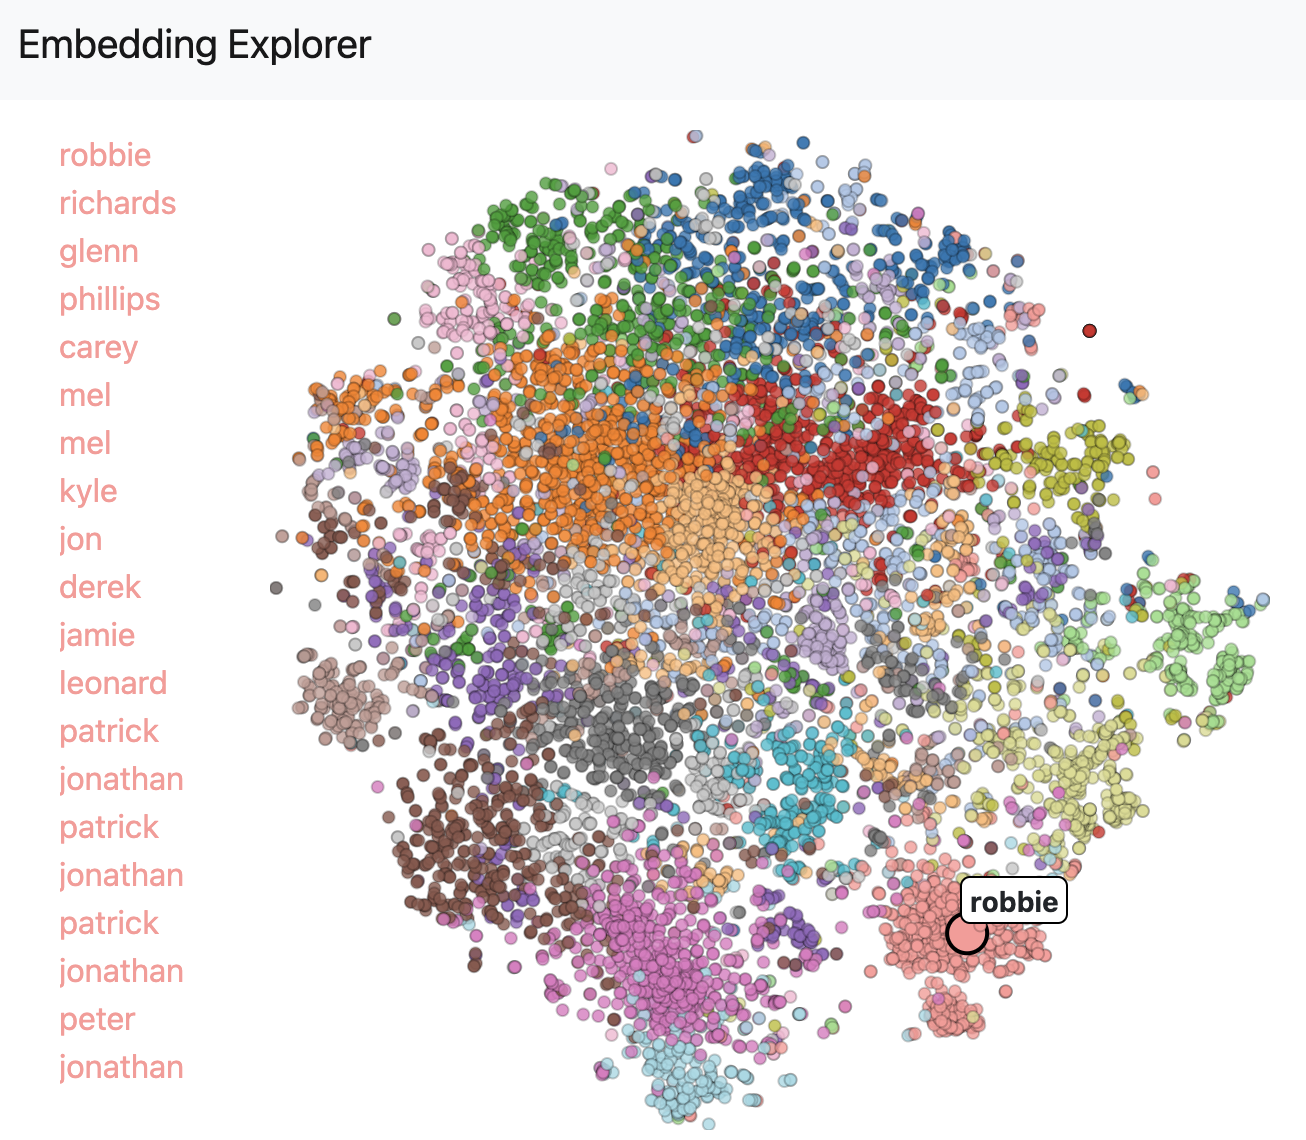

Fortunately, GloVe is available by PyTorch's *torchtext* package (requiring the downloading of a $~823$MB file).


In [ ]:
glove = vocab.GloVe(name="6B", dim=50)

In [ ]:
# 'stoi' – A dictionary of string to the index of the associated vector in glove
for i, item in enumerate(glove.stoi.items()):
    if i<=10:
      print(item)
    else:
      break

('the', 0)
(',', 1)
('.', 2)
('of', 3)
('to', 4)
('and', 5)
('in', 6)
('a', 7)
('"', 8)
("'s", 9)
('for', 10)


Since tweets often have mispellings, we'll need to ignore words that do not appear in the Glove embeddings. Let's sanity check that there are enough words for us to work with.

In [ ]:
for i, line in enumerate(data):
    if i > 10:
        break
    print(f'Tweet {i}: {sum(int(w in glove.stoi) for w in split_tweet(line[-1]))}/{len(line[-1])}') # how many words appear in Glove dict out of total words in the tweet

Tweet 0: 15/77
Tweet 1: 19/117
Tweet 2: 18/103
Tweet 3: 18/93
Tweet 4: 4/20
Tweet 5: 9/64
Tweet 6: 13/79
Tweet 7: 11/62
Tweet 8: 23/101
Tweet 9: 8/48
Tweet 10: 9/38


## Prepare data for training
We will only use  $1/29$  of the data in the file, so that this demo runs relatively quickly. So we only look at one in every $29$ tweets. For these tweets, we use $60\%$ as training, $20\%$ as validation, and $20\%$ as test.

Since we are going to store the individual words in a tweet, we will defer looking up the word embeddings. Instead, we will store the index of each word in a PyTorch tensor. Our choice is the most memory-efficient, since it takes fewer bits to store an integer index than a 50-dimensional vector for a word.

In [ ]:
def get_tweet_words(embeddings, data):
    train_data, valid_data, test_data = [], [], []
    for i, line in enumerate(data):
        if i % 29 == 0:
            tweet = line[-1]
            idxs = [embeddings.stoi[w] for w in split_tweet(tweet) if w in embeddings.stoi]  # keep the index of words that have embeddings
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train_data.append((idxs, label))
            elif i % 5 == 4:
                valid_data.append((idxs, label))
            else:
                test_data.append((idxs, label))
    return train_data, valid_data, test_data

train_data, valid_data, test_data = get_tweet_words(glove, data)

Here's what an element of the training set looks like:

In [ ]:
print(train_data[0][])
print(train_data[0][10]) # label

tensor([  41, 5281,   61,   41,   33,    4,  580,    5, 3050,   69,   60])
tensor(0)


In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

32889
10967
10961


## Batching
Unfortunately, we will not be able to use DataLoader with a batch_size of greater than one. This is because each tweet has a different shaped tensor. PyTorch implementation of DataLoader class expects all data samples to have the same shape. So, if we just create a DataLoader for batching, it will throw an error when we try to iterate over its elements.

How to deal with this?


1.   Zero pad - we can pad shorter sequences with zero inputs. Pytorch provides several utilizies to that aim, including
`torch.nn.utils.rnn.pad_sequence`.

2.   Batch together sequences of the same length.

Here, we will adopt the second approach. The reason to do that is that our network will end up looking only at the hidden state of the RNN after the entire sequence has been processed, so **we should use the output corresponding to the final word and not the zero padding in the end**.
To that aim, we will define a dedicate function which essentially first stores the tweets in bins by lengths, and then converts each bin into batches (where the final tweets which do not fit into the batches are dropped). In particular, we use by defult batch size $B=64$.



In [ ]:
class TweetBatcher:
    def __init__(self, tweets, batch_size=64, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader( # DataLoader is an iterable you can iterate over with next(iter(dataloader)) of looping
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True, # Because we specified shuffle=True, after we iterate over all batches the data is shuffled
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}

    def __iter__(self): # create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im) # 'yield' returns a generator - simply written iterators using a function, returning the data without affecting or exiting it.
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Let's see how this shapes our data:

In [ ]:
for i, (tweets, labels) in enumerate(TweetBatcher(train_data, drop_last=True)):
    if i > 10: break
    print(tweets.shape, labels.shape)

torch.Size([64, 33]) torch.Size([64])
torch.Size([64, 13]) torch.Size([64])
torch.Size([64, 11]) torch.Size([64])
torch.Size([64, 12]) torch.Size([64])
torch.Size([64, 5]) torch.Size([64])
torch.Size([64, 12]) torch.Size([64])
torch.Size([64, 6]) torch.Size([64])
torch.Size([64, 24]) torch.Size([64])
torch.Size([64, 22]) torch.Size([64])
torch.Size([64, 14]) torch.Size([64])
torch.Size([64, 14]) torch.Size([64])


Finally, we can load the data in mini-batches of idential sizes to be processed during training.

In [ ]:
# Divide data into batches
train_loader = TweetBatcher(train_data, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid_data, batch_size=64, drop_last=False)
test_loader = TweetBatcher(test_data, batch_size=64, drop_last=False)

# Introducing Embedding layer

Before defining our models, we will define a word embedding layer, using PyTorch *nn.Embedding* layer. Our motivation of using an embedding layer which utilizes GloVe is that it lets us look up the embeddings of multiple words simultaiously, so that our network can train and infer faster.

In [ ]:
# Create an `nn.Embedding` layer and load data from pretrained `glove.vectors`
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

# Example: we use the forward function of glove_emb to lookup the embedding of each word in the first tweet in the trainin set
print(f'{glove_emb} is a vocabulary of 40K words!')
tweet, label = train_data[0]
tweet_emb = glove_emb(tweet) # this is equivalnet to glove.vectors[tweet]
print(tweet.shape, tweet_emb.shape)

Embedding(400000, 50) is a vocabulary of 40K words!
torch.Size([11]) torch.Size([11, 50])


# Recurrent Neural Networks
## Model 1: Vanilla RNN
Our first model is a vanilla RNN with a fully-connected layer applied to the last hidden state, mapping its value into a $2\times 1$ vector (which is converted to a distribution in the computation of the cross entropy loss).

Specifically, [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) applies a multi-layer RNN with tanh/ReLU
non-linearity to an input sequence. For each element in the input sequence, each layer computes the hidden state using the hidden state of the previous layer or the initial hidden state at time 0 (h_0 defaults to zeros if not provided):

## Model 2 & 3: GRU & LSTM
Our second model is a GRU with a fully-connected layer applied to the last hidden state, mapping its value into a  2×1  vector (which is converted to a distribution in the computation of the cross entropy loss).

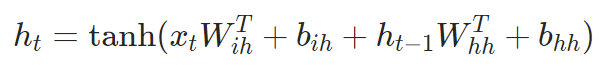

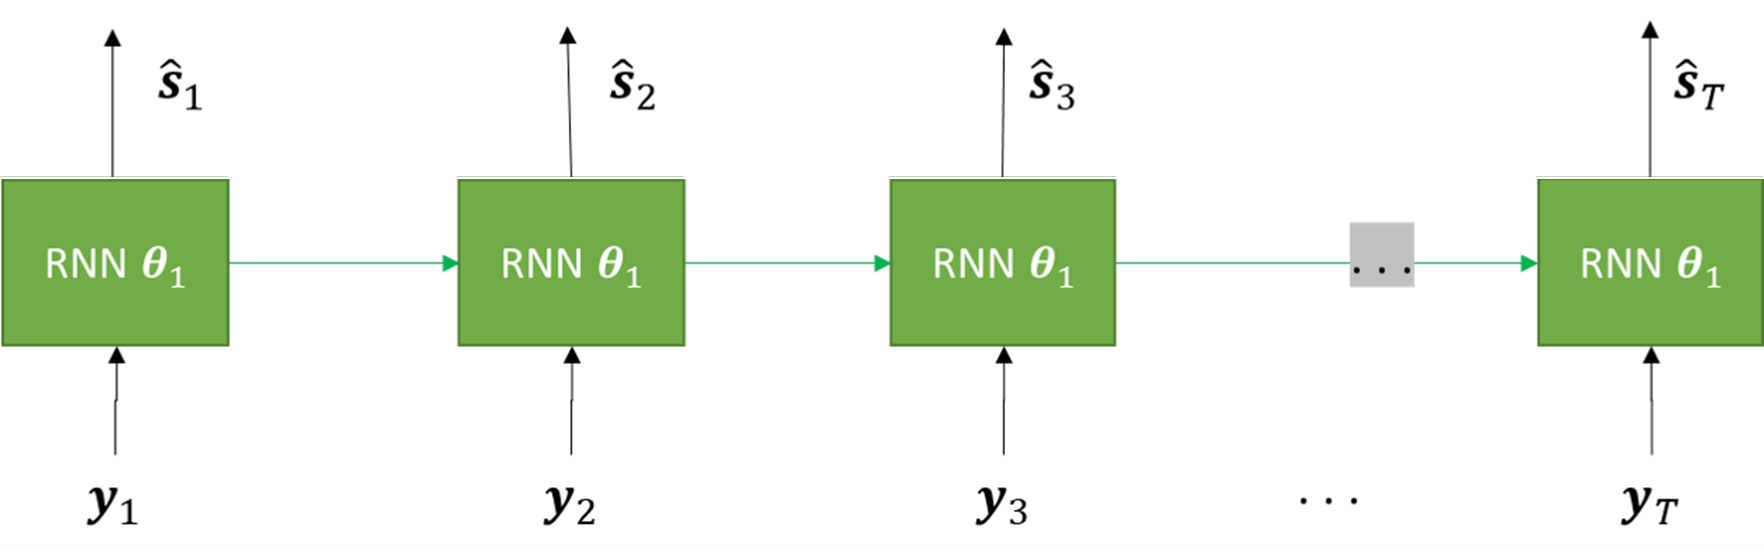

In [ ]:
input_size = 50
def model_info(RNN_type):
  RNN_type(torch.randn(3, input_size))
  print(summary(RNN_type, input_size=(1,input_size), device="cpu"))
  print('\n')
  for name, parameter in RNN_type.named_parameters():
    print(name, parameter.shape)

def RNN_types(hidden_size):
   return [nn.RNN(input_size, hidden_size, batch_first=True), # if True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
            nn.GRU(input_size, hidden_size, batch_first=True),
            nn.LSTM(input_size, hidden_size, batch_first=True)]

for RNN_type in RNN_types(2):
  model_info(RNN_type)


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 2]                    108
Total params: 108
Trainable params: 108
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


weight_ih_l0 torch.Size([2, 50])
weight_hh_l0 torch.Size([2, 2])
bias_ih_l0 torch.Size([2])
bias_hh_l0 torch.Size([2])
Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [1, 2]                    324
Total params: 324
Trainable params: 324
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


weight_ih_l0 torch.Size([6, 50])
weight_hh_l0 torch.Size([6, 2])
bias_ih_l0 torch.Size([6])
bias_hh_l0 torch.Size([6])
Layer (type:depth-idx)                   Output Shape   

In [ ]:
class TweetRNNs(nn.Module): # nn.Module is a base class for all neural network modules in Pytorch. Our model should also subclass this class.
    def __init__(self, RNN_type, input_size, hidden_size, num_classes):
        super().__init__() #  The super() function is used to give access to methods and properties of a parent class
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = RNN_type
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Forward propagate the RNN
        _, h_n = self.rnn(x) # the first output argument h_t, thrown here by '_', contains the output features from the last layer of the RNN, for each t; while the second containing the final hidden state for each element in the batch.
        h_n = h_n[0] if len(h_n) > 1 else h_n # this is for LSTM model holding Outputs: output, (h_n, c_n)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.squeeze(h_n, 0))
        return out

# Train and Validation
Next, we formulate the training fucntion, which also implements validation.
We begin with defining an intermediate function for computing the accuracy of a given model over a dataset.

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        tweets, labels = tweets.to(device), labels.to(device)
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

The trainin function uses the Adam optimizer with the cross entropy loss (since we are dealing with a classification problem).
The training function also computes the validation error on each epoch.

In [ ]:
criterion = nn.CrossEntropyLoss() # applies a softmax and then computes the negative log-likelihood loss

def train(model, optimizer, num_epochs=20):
    train_acc, valid_acc = [], []
    epochs = []
    # Loop over epochs

    model = model.to(device)
    for epoch in range(num_epochs):
        # Loop over batches
        for tweets, labels in train_loader:
            tweets, labels = tweets.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        # Save error on each epoch
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.584382; Train Acc 0.666162; Val Acc 0.670192
Epoch 2; Loss 0.677680; Train Acc 0.673264; Val Acc 0.673201
Epoch 3; Loss 0.508963; Train Acc 0.676452; Val Acc 0.675299
Epoch 4; Loss 0.682874; Train Acc 0.679798; Val Acc 0.678764
Epoch 5; Loss 0.523214; Train Acc 0.684438; Val Acc 0.681134
Epoch 6; Loss 0.515639; Train Acc 0.684912; Val Acc 0.684873
Epoch 7; Loss 0.557191; Train Acc 0.685922; Val Acc 0.685329
Epoch 8; Loss 0.580615; Train Acc 0.687027; Val Acc 0.681499
Epoch 9; Loss 0.592837; Train Acc 0.684880; Val Acc 0.681499
Epoch 10; Loss 0.576865; Train Acc 0.687532; Val Acc 0.681499
Epoch 11; Loss 0.506123; Train Acc 0.692866; Val Acc 0.691256
Epoch 12; Loss 0.591420; Train Acc 0.694192; Val Acc 0.688702
Epoch 13; Loss 0.536400; Train Acc 0.698201; Val Acc 0.691164
Epoch 14; Loss 0.468803; Train Acc 0.700852; Val Acc 0.694173
Epoch 15; Loss 0.583735; Train Acc 0.702146; Val Acc 0.696727
Epoch 16; Loss 0.644368; Train Acc 0.700884; Val Acc 0.695997
Epoch 17; Loss 0.

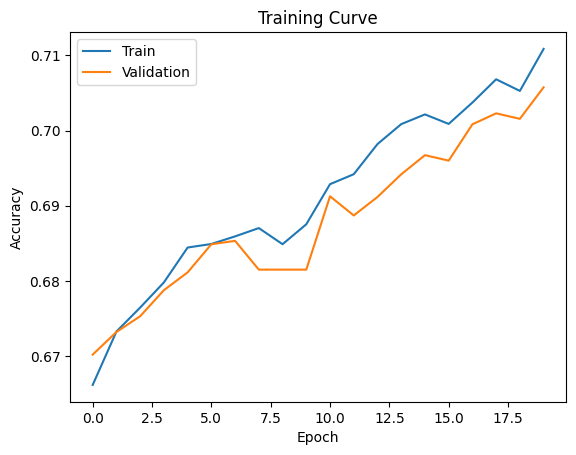

Epoch 1; Loss 0.674813; Train Acc 0.595391; Val Acc 0.594146
Epoch 2; Loss 0.645373; Train Acc 0.644413; Val Acc 0.642655
Epoch 3; Loss 0.645689; Train Acc 0.671654; Val Acc 0.675481
Epoch 4; Loss 0.548453; Train Acc 0.677683; Val Acc 0.679675
Epoch 5; Loss 0.530418; Train Acc 0.682639; Val Acc 0.685055
Epoch 6; Loss 0.582915; Train Acc 0.687405; Val Acc 0.687608
Epoch 7; Loss 0.584179; Train Acc 0.689141; Val Acc 0.689067
Epoch 8; Loss 0.609745; Train Acc 0.691477; Val Acc 0.693079
Epoch 9; Loss 0.548884; Train Acc 0.691856; Val Acc 0.692988
Epoch 10; Loss 0.550000; Train Acc 0.695202; Val Acc 0.695085
Epoch 11; Loss 0.582010; Train Acc 0.695202; Val Acc 0.694812
Epoch 12; Loss 0.537686; Train Acc 0.696938; Val Acc 0.698824
Epoch 13; Loss 0.651953; Train Acc 0.696402; Val Acc 0.696635
Epoch 14; Loss 0.603414; Train Acc 0.697506; Val Acc 0.697456
Epoch 15; Loss 0.532693; Train Acc 0.701231; Val Acc 0.701377
Epoch 16; Loss 0.569574; Train Acc 0.702178; Val Acc 0.703292
Epoch 17; Loss 0.

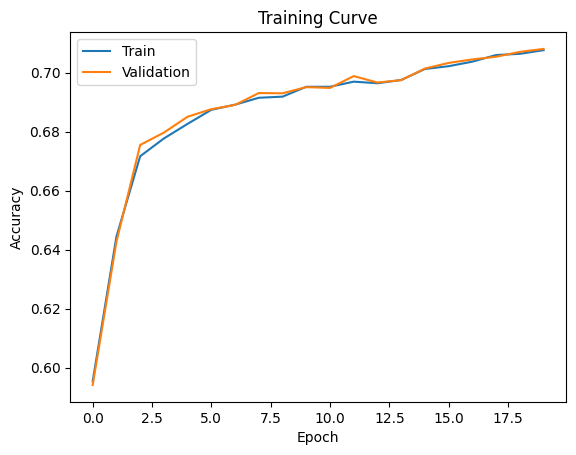

Epoch 1; Loss 0.669524; Train Acc 0.605619; Val Acc 0.603994
Epoch 2; Loss 0.640724; Train Acc 0.651989; Val Acc 0.651591
Epoch 3; Loss 0.618720; Train Acc 0.659628; Val Acc 0.655877
Epoch 4; Loss 0.545378; Train Acc 0.674653; Val Acc 0.673840
Epoch 5; Loss 0.606819; Train Acc 0.680177; Val Acc 0.680496
Epoch 6; Loss 0.603921; Train Acc 0.682260; Val Acc 0.681590
Epoch 7; Loss 0.572428; Train Acc 0.686616; Val Acc 0.686514
Epoch 8; Loss 0.542306; Train Acc 0.687342; Val Acc 0.689158
Epoch 9; Loss 0.583725; Train Acc 0.688826; Val Acc 0.690800
Epoch 10; Loss 0.605490; Train Acc 0.689457; Val Acc 0.691256
Epoch 11; Loss 0.589108; Train Acc 0.692330; Val Acc 0.694994
Epoch 12; Loss 0.573536; Train Acc 0.693908; Val Acc 0.696088
Epoch 13; Loss 0.580005; Train Acc 0.693371; Val Acc 0.692441
Epoch 14; Loss 0.525903; Train Acc 0.696402; Val Acc 0.698003
Epoch 15; Loss 0.606437; Train Acc 0.697096; Val Acc 0.697365
Epoch 16; Loss 0.498820; Train Acc 0.697633; Val Acc 0.698368
Epoch 17; Loss 0.

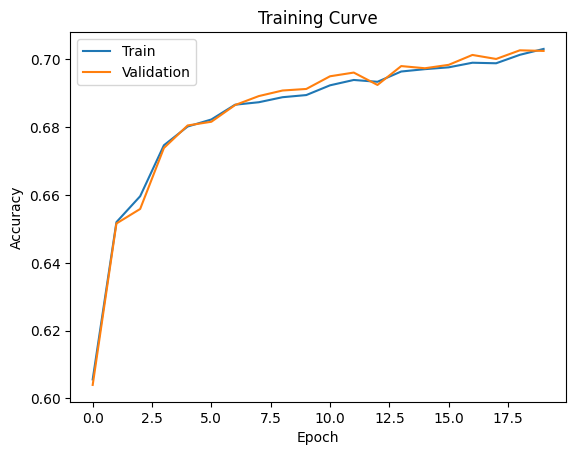

In [ ]:
hidden_size = 50
lrs = [2e-4, 5e-5, 5e-5]
models = []
for i, RNN_type in enumerate(RNN_types(hidden_size)):
  model = TweetRNNs(RNN_type, input_size, hidden_size, 2)
  optimizer = torch.optim.Adam(model.parameters(), lrs[i])
  # Train and produce training curve and validation curve
  train(model, optimizer)
  models.append(model)

Set the hidden state size as $=50$.

In [ ]:
# Compute test accuracy
for model in models:
  print(get_accuracy(model, test_loader))

0.7027643463187665
0.7025818812152176
0.6971079281087492
